# Summary plots
This notebook create the plots summarizing results of the cmVIP method and the comparison with eVIP results. 

In [1]:
import os
import json

import pandas as pd
import numpy as np

from plotly import graph_objects as go
from plotly import express as px
from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default = "notebook_connected" # Set to "svg" or "png" for non-interactive plots

# Create data/l1k_cp_predictions.csv file

In [2]:
expression = pd.read_csv('outputs/benchmark_results_expression.csv')
morphology = pd.read_csv('outputs/benchmark_results.csv')
results_cp = morphology[['wild_type', 'mutant', 'adjusted_impact_test', 
                         'is_sig_impact_test', 'adjusted_strength_test',
                         'prediction', 'directionality_test']]
results_l1k = expression[['wild_type', 'mutant', 'adjusted_impact_test', 
                         'is_sig_impact_test', 'adjusted_strength_test',
                         'prediction', 'directionality_test']]

col_names = ['wt', 'mut', 'impact-pvalue', 'impactful',
             'dir-pvalue', 'class', 'direction']

results_cp.columns = col_names[:2] + ['cp-' + c for c in col_names[2:]]
results_l1k.columns = col_names[:2] + ['l1k-' + c for c in col_names[2:]]

results_data = results_cp.merge(results_l1k, on=['mut'], how='inner')

In [3]:
with open('outputs/signal_strength_cp.json') as fp_cp, open('outputs/signal_strength_l1k.json') as fp_l1k:
    strength_cp = pd.Series(json.load(fp_cp), name='cp-signal-strength')
    strength_l1k = pd.Series(json.load(fp_l1k), name='l1k-signal-strength')
    strength = pd.DataFrame([strength_cp, strength_l1k]).T
    strength = strength.dropna()

In [4]:
results_data = results_data.merge(strength, left_on='mut', right_index=True)

In [5]:
results_data['l1k-dir-sign'] = 2 * results_data["l1k-direction"] - 1
results_data['cp-dir-sign'] = 2 * results_data["cp-direction"] - 1
results_data['l1k-norm-dir'] = -np.log10(results_data["l1k-dir-pvalue"]) * results_data["l1k-dir-sign"] + 0.2*np.random.random(len(results_data))
results_data['cp-norm-dir'] = -np.log10(results_data["cp-dir-pvalue"]) * results_data["cp-dir-sign"] + 0.2*np.random.random(len(results_data))
results_data['cp-neg-log-p-impact'] = -np.log10(results_data['cp-impact-pvalue'])
results_data['l1k-neg-log-p-impact'] = -np.log10(results_data['l1k-impact-pvalue'])
results_data['gene'] = results_data.mut.str.split('_', expand=True)[0]
results_data.loc[results_data['l1k-class'] == 'NI', 'l1k-class'] = 'NT'
results_data.loc[results_data['cp-class'] == 'NI', 'cp-class'] = 'NT'

In [6]:
colors={"LOF": "dodgerblue", "NT": "gray", "NI": "gray",
        "GOF": "red", "COF": "darkorchid"}

# P-value impact test distribution plot

In [7]:
l1k = results_data["l1k-impactful"] == True
cp = results_data["cp-impactful"] == True
results_data.loc[~l1k & ~cp, "Agreement"] = "Both: Non-impactful"
results_data.loc[~l1k & cp, "Agreement"] = "CellPainting: impactful" 
results_data.loc[l1k & ~cp, "Agreement"] = "L1000: impactful"
results_data.loc[l1k & cp, "Agreement"] = "Both: Impactful"

colormap = {'Both: Non-impactful': 'gray',
'CellPainting: impactful': 'magenta',
'L1000: impactful': 'cyan',
'Both: Impactful': 'lime'}


impact_counts = pd.DataFrame(data=results_data.groupby("Agreement")["mut"].count())
impact_counts["color"] = impact_counts.index
impact_counts.index = ["L1000: impactful","Both: Non-impactful","Both: Impactful","CellPainting: impactful"]
impact_counts = impact_counts['mut'].to_dict()

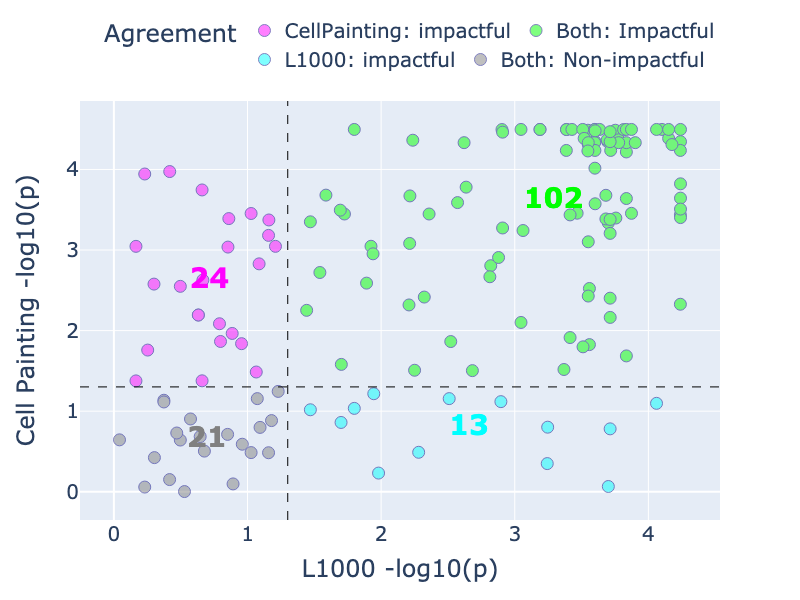

In [8]:
to_plot = pd.DataFrame({
    'L1000 -log10(p)': -np.log10(results_data["l1k-impact-pvalue"]),
    'Cell Painting -log10(p)': -np.log10(results_data["cp-impact-pvalue"]),
    'Allele': results_data['mut'],
    'Agreement': results_data['Agreement']})

fig = px.scatter(to_plot, x="L1000 -log10(p)", y="Cell Painting -log10(p)",
                 color='Agreement', color_discrete_map=colormap, hover_data=['Allele'],
                 title='P-value impact test distribution')
fig.update_traces(marker_line_width=1, marker_line_color='navy', marker_size=12, opacity=0.5)
fig.update_layout(autosize=False,
                  width=800,
                  height=600,
                  font=dict(size=20),
                  title='',
                 )
fig.add_vline(x=-np.log10(0.05), line_width=1, line_dash="dash", line_color="black")
fig.add_hline(y=-np.log10(0.05), line_width=1, line_dash="dash", line_color="black")

groupby = to_plot.groupby('Agreement')[['L1000 -log10(p)','Cell Painting -log10(p)']]
counts = groupby.mean()
counts['count'] = groupby.count().iloc[:, 0]
counts.reset_index(inplace=True)
counts['count'] = counts['count'].apply('<b>{0}</b>'.format)
annotations = go.Scatter(x=counts["L1000 -log10(p)"],
                         y=counts["Cell Painting -log10(p)"],
                         text=counts['count'],
                         mode='text',
                         textposition='middle center',
                         textfont={"color": counts['Agreement'].apply(colormap.get),
                                   'size': 28},
                         hoverinfo='skip',
                         showlegend=False
                        )
fig.add_trace(annotations)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.05,
    xanchor="right",
    x=1
))
fig

# Phenotype Replicability plot

In [9]:
wt_strength = pd.DataFrame([strength_cp, strength_l1k]).T
wt_strength = wt_strength.dropna()
wt_strength = wt_strength[wt_strength.index.str.contains('_WT.c')]
wt_strength.index.name='allele'
wt_strength.reset_index(inplace=True)
wt_strength['gene'] = wt_strength.allele.str.split('_', expand=True)[0]

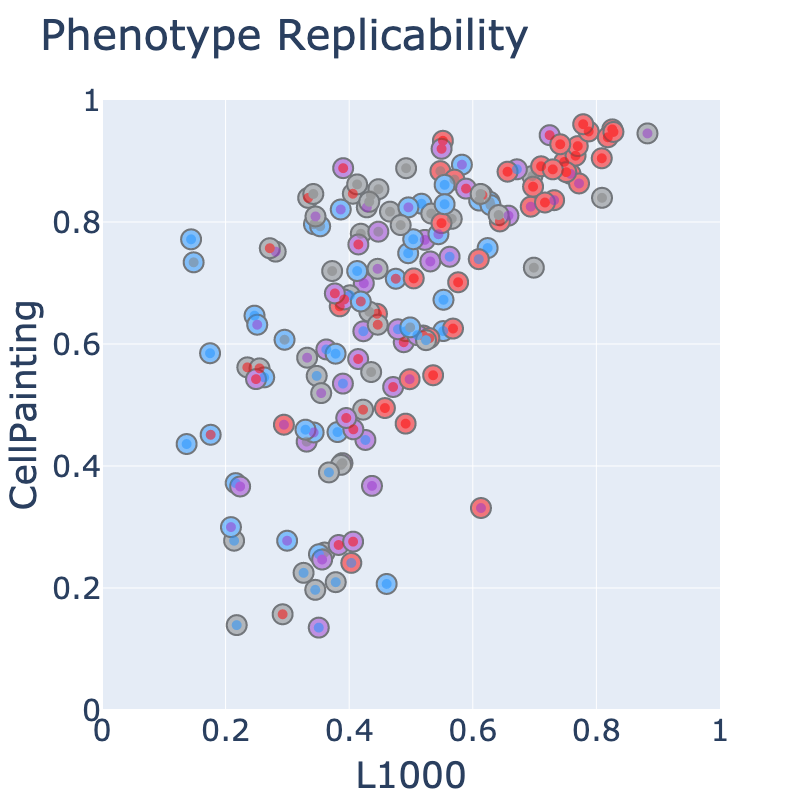

In [10]:
fig = go.Figure()
cp_trace = go.Scatter(x=results_data['l1k-signal-strength'],
                      y=results_data['cp-signal-strength'],
                      mode='markers',
                      marker=dict(
                          color=results_data['cp-class'].apply(colors.get),
                          size=10),
                      opacity=0.5,
                      name='CellPainting',
                      text=results_data['cp-class'],
                      hoverinfo='skip'
                      )
l1k_trace = go.Scatter(x=results_data['l1k-signal-strength'],
                       y=results_data['cp-signal-strength'],
                       mode='markers',
                       marker=dict(
                           color=results_data['l1k-class'].apply(colors.get),
                           line=dict(width=2, color='black'),
                           size=20),
                       opacity=0.5,
                       name='',
                       customdata=results_data[['mut', 'l1k-class', 'cp-class']].values,
                       hovertemplate=('<b>Allele:%{customdata[0]}</b><br>'
                                      'L1000:%{customdata[1]}<br>'
                                      'CellPainting: %{customdata[2]}'),
                      )
wt_trace = go.Scatter(x=wt_strength['l1k-signal-strength'],
                      y=wt_strength['cp-signal-strength'],
                      text=wt_strength['allele'],
                      mode='markers+text',
                      marker_symbol='circle-open',
                      marker_size=12,
                      hoverinfo='text',
                      textfont_size=8,
                      textposition="top right"
                     ) 
fig.add_trace(l1k_trace)
fig.add_trace(cp_trace)
#fig.add_trace(
#    go.Scatter(x=[0,1], y=[0,1], mode='lines',
#              line=dict(width=2, dash='dash', color='grey'))
#)
#fig.add_trace(wt_trace)
fig.update_layout(title='Phenotype Replicability', showlegend=False,
                  hoverlabel=dict(bgcolor="white",),
                  autosize=False,
                  width=800,
                  height=800,
                  font=dict(size=30),
                 )
fig.update_xaxes(title='L1000')
fig.update_yaxes(title='CellPainting')
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])

fig

# Directionality test plot

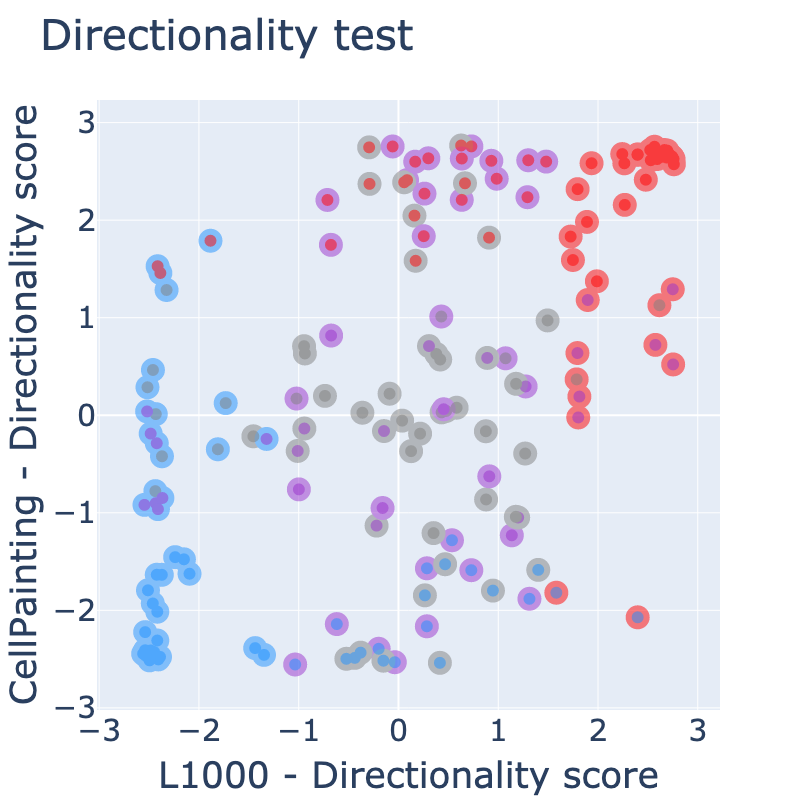

In [11]:
fig = go.Figure()
cp_trace = go.Scatter(x=results_data['l1k-norm-dir'],
                      y=results_data['cp-norm-dir'],
                      mode='markers',
                      marker=dict(
                          color=results_data['cp-class'].apply(colors.get),
                          size=12),
                      opacity=0.5,
                      name='CellPainting',
                      text=results_data['cp-class'],
                      hoverinfo='skip'
                      )
l1k_trace = go.Scatter(x=results_data['l1k-norm-dir'],
                       y=results_data['cp-norm-dir'],
                       mode='markers',
                       marker=dict(
                           color=results_data['l1k-class'].apply(colors.get),
                           size=24),
                       opacity=0.5,
                       name='',
                       customdata=results_data[['mut', 'l1k-class', 'cp-class']].values,
                       hovertemplate=('<b>Allele:%{customdata[0]}</b><br>'
                                      'L1000:%{customdata[1]}<br>'
                                      'CellPainting: %{customdata[2]}'),
                      )

fig.add_trace(l1k_trace)
fig.add_trace(cp_trace)
fig.update_layout(title='Directionality test', showlegend=False,
                  hoverlabel=dict(bgcolor="white",),
                  autosize=False,
                  width=800,
                  height=800,
                  font=dict(size=30),
                 )
fig.update_xaxes(title='L1000 - Directionality score')
fig.update_yaxes(title='CellPainting - Directionality score')
fig.update_annotations(font_size=22)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.05,
    xanchor="right",
    x=1
))

fig

# Functional classification

In [12]:
gene_funcs = pd.read_csv('inputs/metadata/l1k/gene_funcs.csv')
to_plot = results_data.merge(gene_funcs, left_on='mut', right_on='x_mutation_status')
to_plot = to_plot[['Functional Classification', 'l1k-class', 'cp-class']]
to_plot = to_plot.melt(id_vars=['Functional Classification'], var_name='Profile', value_name='prediction')
to_plot['Profile'] = to_plot['Profile'].apply({'l1k-class': 'L1000', 'cp-class': 'CellPainting'}.get)
to_plot['Functional Classification'] = to_plot['Functional Classification'].apply({'UNKN': 'Unknown', 'ONC': 'Oncogene', 'TSG': 'TSG'}.get)

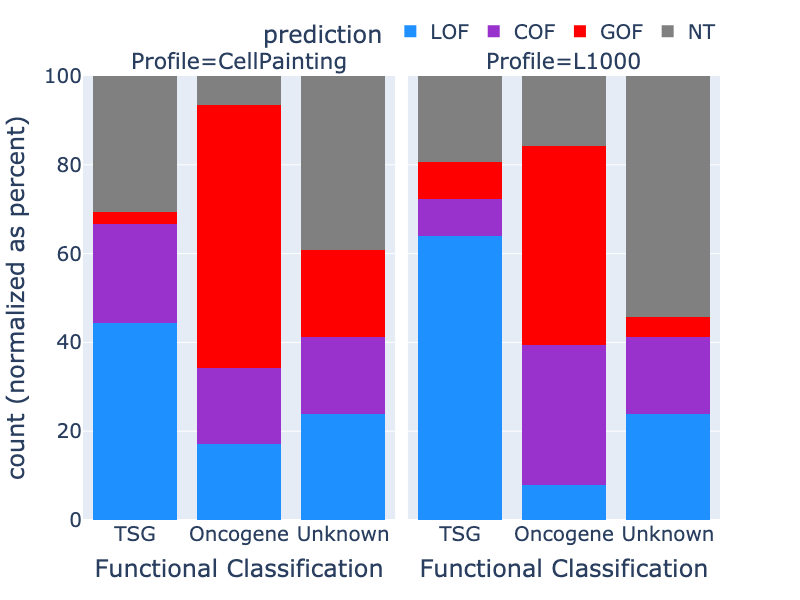

In [13]:
fig = px.histogram(to_plot, x='Functional Classification', color='prediction', barmode='stack',
                   color_discrete_map=colors, title='', facet_col='Profile',
                   barnorm='percent',
                   category_orders={'Profile': ['CellPainting', 'L1000'],
                                    'Functional Classification': ['TSG', 'Oncogene', 'Unknown'],
                                    'prediction': ['LOF', 'COF', 'GOF', 'NT']
                                   })
fig.update_layout(autosize=False,
                  width=800,
                  height=600,
                  font=dict(size=20),
                 )
fig.update_annotations(font_size=22)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.05,
    xanchor="right",
    x=1
))
fig

In [14]:
to_plot = results_data.merge(gene_funcs, left_on='mut', right_on='x_mutation_status')
to_plot = to_plot[['Functional Classification', 'l1k-class', 'cp-class', 'x_mutation_status']]
to_plot = to_plot.melt(id_vars=['Functional Classification', 'x_mutation_status'], 
                       var_name='Profile', value_name='prediction')

to_plot[to_plot['Profile']=='cp-class'][
    ['Functional Classification', 'x_mutation_status', 'prediction']
].to_csv('outputs/cp-predictions.csv', index=False)

# Sparkler plots

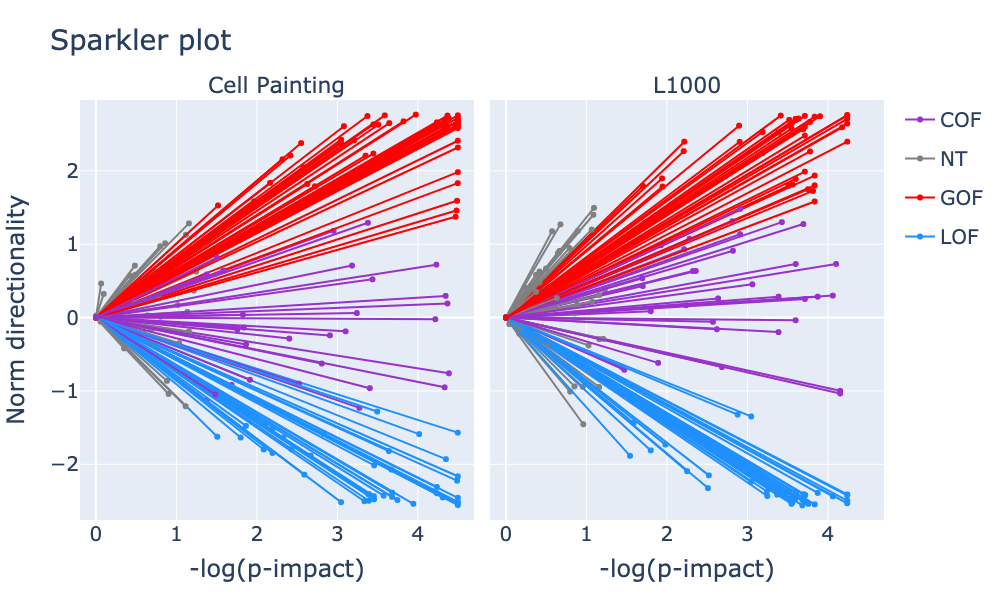

In [15]:
min_x = min(results_data['cp-neg-log-p-impact'].min(),
            results_data['l1k-neg-log-p-impact'].min()) - 0.2
max_x = max(results_data['cp-neg-log-p-impact'].max(),
            results_data['l1k-neg-log-p-impact'].max()) + 0.2
min_y = min(results_data['cp-norm-dir'].min(),
            results_data['l1k-norm-dir'].min()) - 0.2
max_y = max(results_data['cp-norm-dir'].max(),
            results_data['l1k-norm-dir'].max()) + 0.2

traced = set()
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Cell Painting", "L1000"),
                    horizontal_spacing=0.02,
                    shared_yaxes=True)
for i, row in results_data.iterrows():
    fig.add_trace(go.Scatter(x=[0, row['cp-neg-log-p-impact']],
                             y=[0, row['cp-norm-dir']],
                             legendgroup=row['cp-class'],
                             name=row['cp-class'],
                             marker=dict(color=colors[row['cp-class']]),
                             showlegend=row['cp-class'] not in traced,
                             text=row['mut'],
                            ),
                  row=1, col=1)
    traced.add(row['cp-class'])
    fig.add_trace(go.Scatter(x=[0, row['l1k-neg-log-p-impact']],
                             y=[0, row['l1k-norm-dir']],
                             legendgroup=row['l1k-class'],
                             name=row['l1k-class'],
                             marker=dict(color=colors[row['l1k-class']]),
                             showlegend=row['l1k-class'] not in traced,
                             text=row['mut']
                            ),
                  row=1, col=2)
    traced.add(row['l1k-class'])
fig.update_layout(title='Sparkler plot',
                  autosize=False,
                  width=1000,
                  height=600,
                  font=dict(size=20),
                 )

fig.update_xaxes(title_text="-log(p-impact)", row=1, col=1)
fig.update_xaxes(title_text="-log(p-impact)", row=1, col=2)
fig.update_yaxes(title_text="Norm directionality", row=1, col=1)
fig.update_xaxes(range=(min_x, max_x), row=1, col=1)
fig.update_xaxes(range=(min_x, max_x), row=1, col=2)
fig.update_yaxes(range=(min_y, max_y), row=1, col=1)
fig.update_yaxes(range=(min_y, max_y), row=1, col=2)
fig.update_annotations(font_size=22)
fig

## Benchmark

In [16]:
benchmark = pd.read_csv('inputs/metadata/benchmark.csv')
benchmark = benchmark.merge(results_data, left_on='Allele', right_on='mut')
benchmark = benchmark[['Allele', 'Reference', 'l1k-class', 'cp-class', 'Prior annotation']]

benchmark

,Allele,Reference,l1k-class,cp-class,Prior annotation
0,ARAF_p.S214F,"Imielinski et al., 2014",COF,LOF,GOF
1,ARAF_p.S214C,"Imielinski et al., 2014",COF,COF,GOF
2,ARAF_p.D429A,"Imielinski et al., 2014",GOF,COF,LOF
3,CTNNB1_p.S37C,"Palacios et al., 1998",GOF,GOF,GOF
4,EGFR_p.ELREA746del,"Greulich et al., 2005",COF,COF,GOF
5,EGFR_p.L858R,"Greulich et al., 2005",NT,LOF,GOF
6,KEAP1_p.G333C,"Hast et al., 2014",LOF,LOF,LOF
7,KRAS_p.G12Y,"Prior et al., 2012",COF,GOF,GOF
8,KRAS_p.G12A,"Prior et al., 2012",GOF,GOF,GOF
9,KRAS_p.G12C,"Prior et al., 2012",GOF,GOF,GOF


# Export data to Morpheus

In [17]:
dffeats = pd.read_parquet('outputs/spherized_morphology_features.parquet')

In [18]:
predicted_mutants = morphology.mutant
predicted_wt = predicted_mutants.map(
    dffeats[['x_mutation_status', 'wild_type']].drop_duplicates().set_index('x_mutation_status').wild_type
)
predicted_alleles = predicted_mutants.append(predicted_wt, ignore_index=True)
dffeats = dffeats[dffeats.x_mutation_status.isin(predicted_alleles)]

In [19]:
allele_corr = dffeats.groupby('x_mutation_status').median().T.corr()

In [20]:
func_labels = pd.read_csv('outputs/cp-predictions.csv')[['x_mutation_status', 'Functional Classification']]

annotations = pd.DataFrame({'x_mutation_status': allele_corr.index.values,
                            'type': map(lambda x: 'REF' if x else 'VAR', allele_corr.index.str.contains('WT')),
                            'gene': allele_corr.index.str.split('_',expand=True).get_level_values(0)})
annotations = annotations.merge(morphology, left_on='x_mutation_status', right_on='mutant', how='left')
annotations = annotations.merge(func_labels, on='x_mutation_status', how='left')

annotations['prediction'].replace('NI', 'NT', inplace=True)

annotations = annotations[['x_mutation_status', 'gene', 'is_sig_impact_test',
                           'is_sig_strength_test', 'is_sig_power_test', 'type',
                           'prediction', 'Functional Classification']]
annotations.set_index('x_mutation_status', inplace=True)
annotations = annotations.join(pd.Series(strength_cp, name='signal_strength'))
annotations['variant'] = list(map(lambda x: x.split('_')[-1], annotations.index.values))

In [21]:
allele_corr.to_excel('outputs/alleles_morpheus.xlsx')
annotations.to_excel('outputs/annotations_morpheus.xlsx')